# Анализ результатов проведения А/В-теста интернет-магазина

В интернет-магазине отделом маркетинга и аналитиками были подготовлены несколько гипотез для увеличения выручки.

В первой части исследования будет проведена приоритезация гипотез для последующего их тестирования и применения с целью увеличения выручки интернет-магазина. В частности, применим методы ICE и RICE для более детального понимания перспектив и важности каждой из гипотез.

Во второй части будут проанализированы результаты А/В-теста:
* Изучим изменение кумулятивной средней выручки и кумулятивного среднего чека
* Определим возможные "выбросы" в данных, которые искажают общую картину и оказывают влияние на конечные результаты
* Очистим данные от "выбросов", и изучим конечный результат применения теста.
* Примем решение об успешности/неуспешности теста и сделаем выводы.

## Описание данных

Данные для первой части
Файл hypothesis.csv.

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части
Файл orders.csv.

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

Файл visitors.csv.

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Выгрузка и подготовка данных

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
import scipy.stats as stats

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [3]:
pd.options.display.max_colwidth = 130
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Предобработка данных

In [4]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Для удобства работы приведем заголовки столбцов в таблице hypothesis к единому виду со всеми строчными буквами.

In [6]:
hypothesis = hypothesis.rename(columns = {
    'Hypothesis':'hypothesis', 
    'Reach':'reach', 
    'Impact':'impact', 
    'Confidence':'confidence',
    'Efforts':'efforts'
    }
)

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Приведем столбцы с датами в обоих датафреймах к корректному формату datetime

In [9]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [10]:
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Работа с пропусками и дубликатами

Проверим данные на наличие пропусков.

In [11]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [12]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

Пропусков в данных нет. Перейдем к анализу дубликатов.

In [13]:
orders.duplicated().sum()

0

In [14]:
visitors.duplicated().sum()

0

Полных дубликатов строк в данных нет, это означает, что данные не требуют очистки от дубликатов.

### Дополнительные проверки

Дополнительно проверим идентичность временных рамок по обеим таблицам, а также изучим общие вводные по каждой из них.

In [15]:
print('Начальная дата по таблице заказов', orders['date'].min())
print('Конечная дата по таблице заказов',orders['date'].max())

Начальная дата по таблице заказов 2019-08-01 00:00:00
Конечная дата по таблице заказов 2019-08-31 00:00:00


In [16]:
print('Начальная дата по таблице посетителей', visitors['date'].min())
print('Конечная дата по таблице посетителей',visitors['date'].max())

Начальная дата по таблице посетителей 2019-08-01 00:00:00
Конечная дата по таблице посетителей 2019-08-31 00:00:00


Даты начала и окончания теста по обеим таблицам идентичны.

In [17]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [18]:
visitors['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

Итого в каждую группу попал 31 посетитель магазина; в части заказов на группу В пришлось 640 заказов, а на группу А - 557. В целом, данные разделены примерно поровну в части посетителей и заказов.

In [19]:
ord_pivot = orders.pivot_table(index='visitorId', columns='group', values='transactionId', aggfunc='count').reset_index()
ord_pivot

group,visitorId,A,B
0,5114589,NaN,1.0
1,6958315,NaN,1.0
2,8300375,1.0,1.0
3,11685486,1.0,NaN
4,39475350,NaN,1.0
...,...,...,...
1026,4266935830,1.0,1.0
1027,4278982564,1.0,NaN
1028,4279090005,NaN,1.0
1029,4281247801,NaN,1.0


Интересно заметить, что некоторые посетители попали сразу в обе группы теста - по своим заказам. На всякий случай посмотрим, сколько таких посетителей всего оказалось.

In [20]:
doubles = ord_pivot.query('A == 1 & B == 1')
doubles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 2 to 1026
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   visitorId  35 non-null     int64  
 1   A          35 non-null     float64
 2   B          35 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.1 KB


Всего таких посетителей 35. Однако, учитывая, что в исследовании будет рассматриваться изменение доходности и конверсии, можно оставить посетителей как есть, поскольку идеально разделить посетителей так, чтобы их заказы попали исключительно в одну из исследуемых групп, невозможно.

Теперь можно приступать к анализу гипотез и результатов А/В-теста.

## Приоритезация гипотез

В данном разделе изучим датафрейм hypothesis и отсортируем предложенные гипотезы по методикам ICE и RICE.

В первом случае мы распределим их по эффекту, уверенности в успехе и затраченным усилиям, а во втором - добавим к изучаемым факторам охват пользовательской аудитории (число пользователей, которых затронет изменение).

In [21]:
hypothesis['ICE'] = round(((hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']),2)
result = hypothesis[['hypothesis','ICE']].sort_values(by=['ICE'],ascending=False)
result

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Согласно полученным данным, топ-3 приоритетными гипотезами будет запуск акции со скидками, два новых канала привлечения и добавление формы подписки на страницы. Естественно, что, благодаря высоким значениям Impact и Confidence, запуск акции будет весьма приоритетным: это поможет быстро привлечь новые деньги. Но здесь может быть и обратная сторона - неизвестно, насколько много людей воспользуется таким предложением, особенно, если в нем будет совсем не то, что нужно посетителям.

Добавление каналов привлечения видится более адекватным решением для работы "вдолгую": приток посетителей будет увеличиваться, а с ними будет расти и выручка. Однако, здесь значительное влияние будет оказывать показатель конверсии и затрат на само привлечение.

Третья по приоритетности гипотеза, добавление подписки на все основные страницы, скорее всего, является достаточно "рабочей": она позволит получать пользователям уведомления о скидках, акциях, новых товарах в категориях и т.д. - а это будет означать, что кто-то из них будет покупать товары и увеличивать выручку магазина.

Теперь добавим ко всем рассматриваемым параметрам охват.

In [22]:
hypothesis['RICE'] = round(((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']),2)
result = hypothesis[['hypothesis','RICE']].sort_values(by=['RICE'],ascending=False)
result

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


С добавлением показателя охвата аудитории, результаты меняются. Теперь топ-3 гипотез скорректирован в зависимости от охвата пользовательской базы.

В максимальном приоритете - добавление функции подписки на все основные страницы. Это логично: функция сразу будет доведена до каждого пользователя, и так или иначе, пользователи будут получать уведомления о разных событиях магазина - а значит скорее всего будут чаще посещать его, зацепляться глазом за какие-либо товары и увеличивать выручку.

Блок рекомендаций в части охвата также логично, что достаточно приоритетен: люди могут искать похожие товары, различные дополнительные аксессуары, запчасти, расходные материалы и прочее, связанное с основным товаром, ради которого они приходят. Так сделано во многих интернет-магазинах и часто оно работает. Сопутствующие товары также увеличат выручку.

Новые каналы привлечения по-прежнему остались в топ-3, и это также логично: с новыми каналами увеличится и охват, особенно среди привлеченных по этим каналам. В остальном - предположение по цели гипотезы остается прежним. Новые пользователи принесут новую выручку, но конечная эффективность должна будет оцениваться по показателям конверсии и дохода на пользователя.

**Вывод**

При добавлении показателя охвата аудитории приоритетность гипотез меняется, поскольку оценивается дополнительный важный фактор - количество людей, затронутыми изменениями. Однако, среди прочего будет необходимо впоследствии, в случае принятия той или иной гипотезы к исполнению, оценивать дополнительные факторы ее эффективности или неэффективности.

## Анализ результатов А/В-теста

### Кумулятивная выручка по группам теста

In [23]:
date_group = orders[['date', 'group']].drop_duplicates()
date_group.head(5)

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [24]:
orders_agg = date_group.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])
orders_agg.head(5)

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [25]:
visitors_agg = date_group.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_agg.head(5)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [26]:
cum_data = orders_agg.merge(
    visitors_agg, left_on=['date', 'group'], right_on=['date', 'group']
)
cum_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
cum_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [27]:
print('Начальная дата по таблице кумулятивной выручки', cum_data['date'].min())
print('Конечная дата по таблице кумулятивной выручки',cum_data['date'].max())

Начальная дата по таблице кумулятивной выручки 2019-08-01 00:00:00
Конечная дата по таблице кумулятивной выручки 2019-08-31 00:00:00


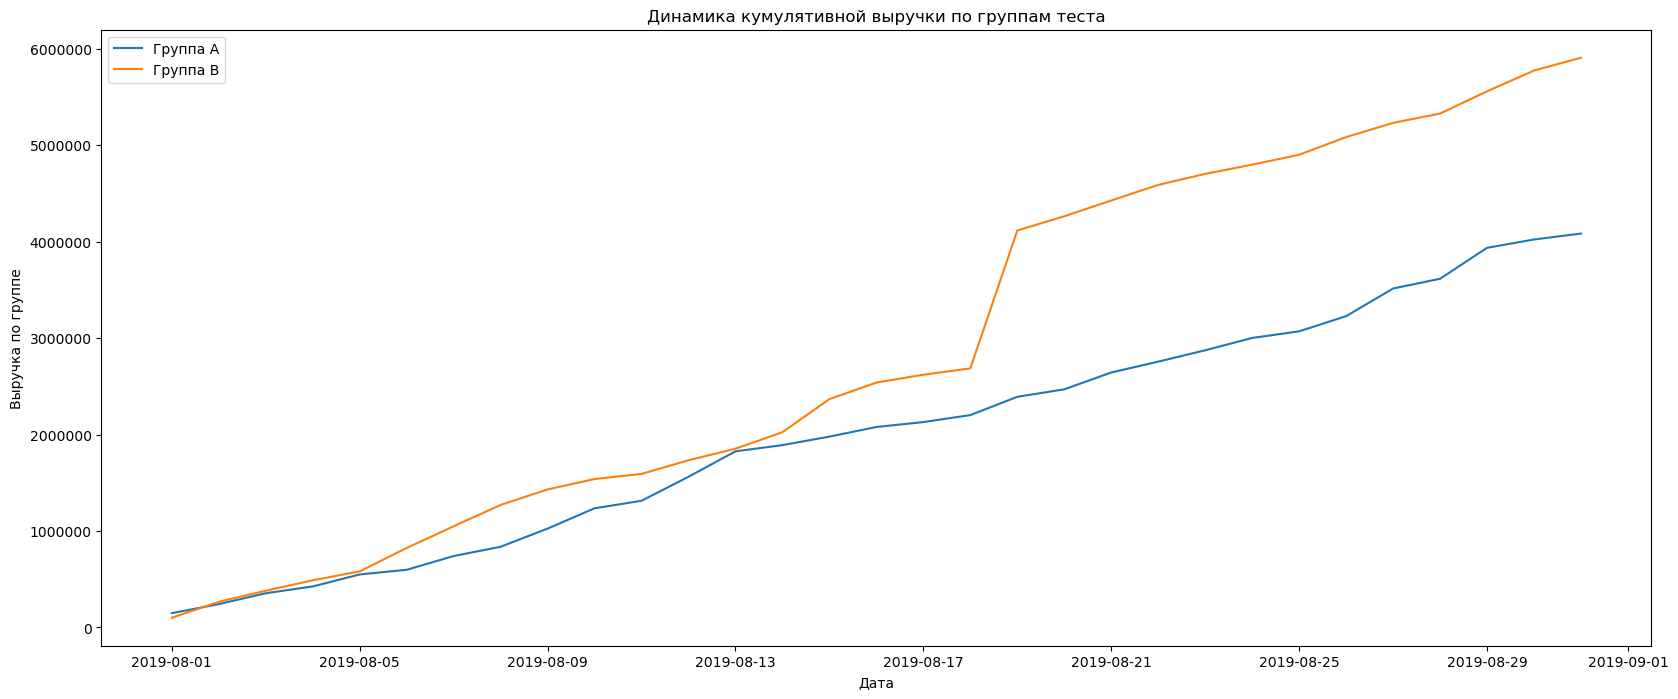

In [28]:
cum_rev_a = cum_data[cum_data['group']=='A'][['date','revenue', 'orders']]

cum_rev_b = cum_data[cum_data['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.figure(figsize=(20,8))
plt.ticklabel_format(style='plain')
plt.plot(cum_rev_a['date'], cum_rev_a['revenue'], label='Группа A')

# Строим график выручки группы B
plt.plot(cum_rev_b['date'], cum_rev_b['revenue'], label='Группа B')
plt.legend() 
plt.ylabel('Выручка по группе')
plt.xlabel('Дата')
plt.title('Динамика кумулятивной выручки по группам теста')
plt.show()

Кумулятивная выручка обеих групп равномерно возрастала примерно до 17-18 августа, причем группа В имела показатели выше. Затем произошло некое событие, которое резко увеличило кумулятивную выручку по группе В, что привело к явному скачку на графике. В дальнейшем равномерный рост продолжился, с группой В значительно выше группы А.

Скорее всего, в указанном периоде произошли отдельные крупные заказы в группе В, что вызвало резкий рост выручки. Также мог произойти резкий рост и числа заказов в определенном моменте, что также могло привести к выбросу на графике.

В дальнейшем скорее всего будет найдена причина такого всплеска и изучены графики с очищенными данными.

### Кумулятивный средний чек по группам теста

Для дальнейшего изучения построим графики кумулятивного среднего чека по группам. Скорее всего, в какой-то момент будет наблюдаться ситуация, дополнительно подкрепляющая гипотеу о том, что в районе 17-21 августа были некие крупные заказы.

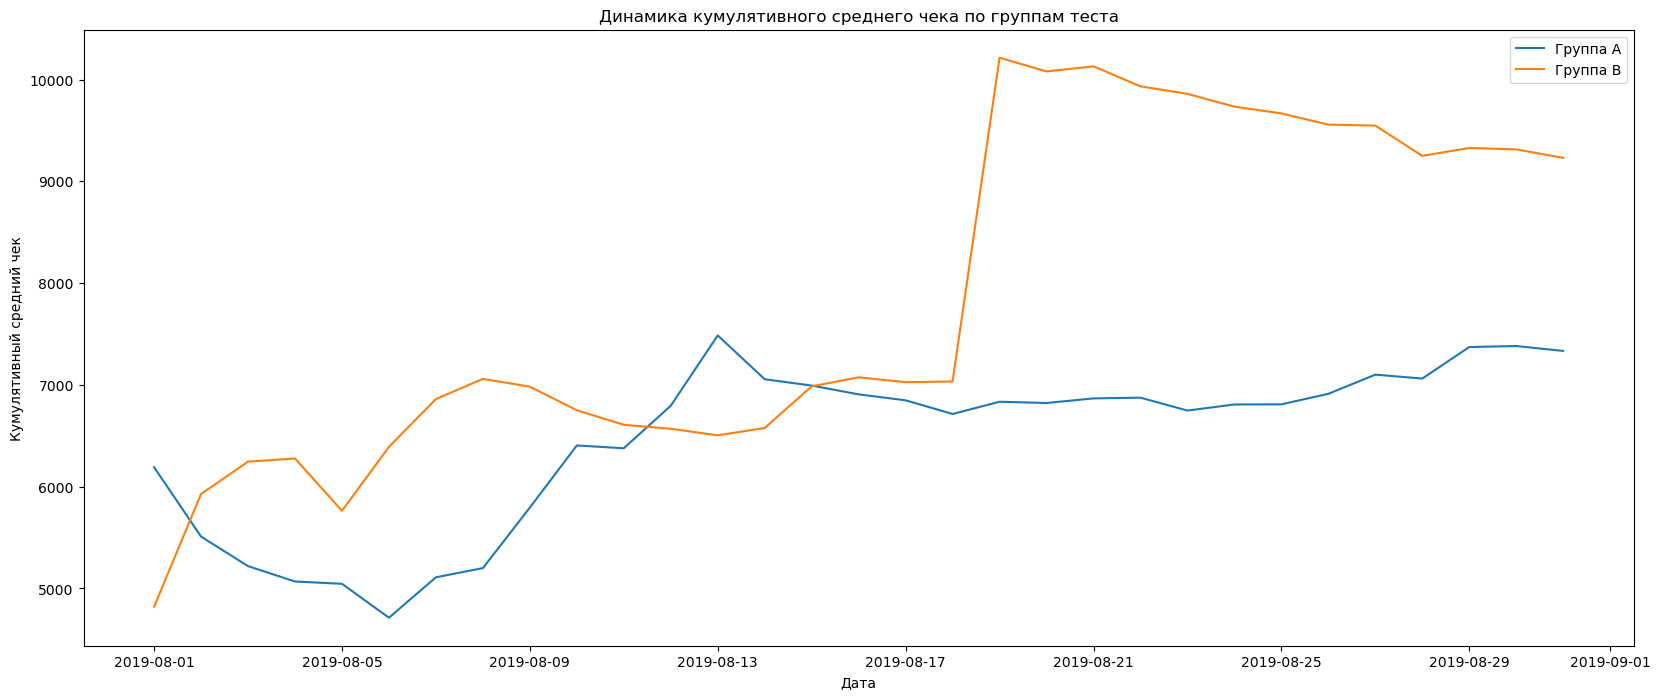

In [29]:
plt.figure(figsize=(20,8))
plt.plot(cum_rev_a['date'], cum_rev_a['revenue']/cum_rev_a['orders'], label='Группа A')
plt.plot(cum_rev_b['date'], cum_rev_b['revenue']/cum_rev_b['orders'], label='Группа B')
plt.legend() 
plt.ylabel('Кумулятивный средний чек')
plt.xlabel('Дата')
plt.title('Динамика кумулятивного среднего чека по группам теста')
plt.show()

В первой половине теста средний чек по группе В возрастал, а по группе А снижался. Затем они начали становиться более равномерными, но действительно произошел некий "выброс", который сделал своеобразную "ступеньку" на графике. При этом, если представить, что выброса нет, то выходит, что чек по группе В постепенно снижается, а по группе А постепенно растет.

В дальнейшем будет определен конкретный выброс и данные будут очищены от искажений.

### Относительное изменение кумулятивного среднего чека группы B к группе A

Теперь перейдем к графику относительного изменения кумулятивного среднего чека группы В к группе А. 

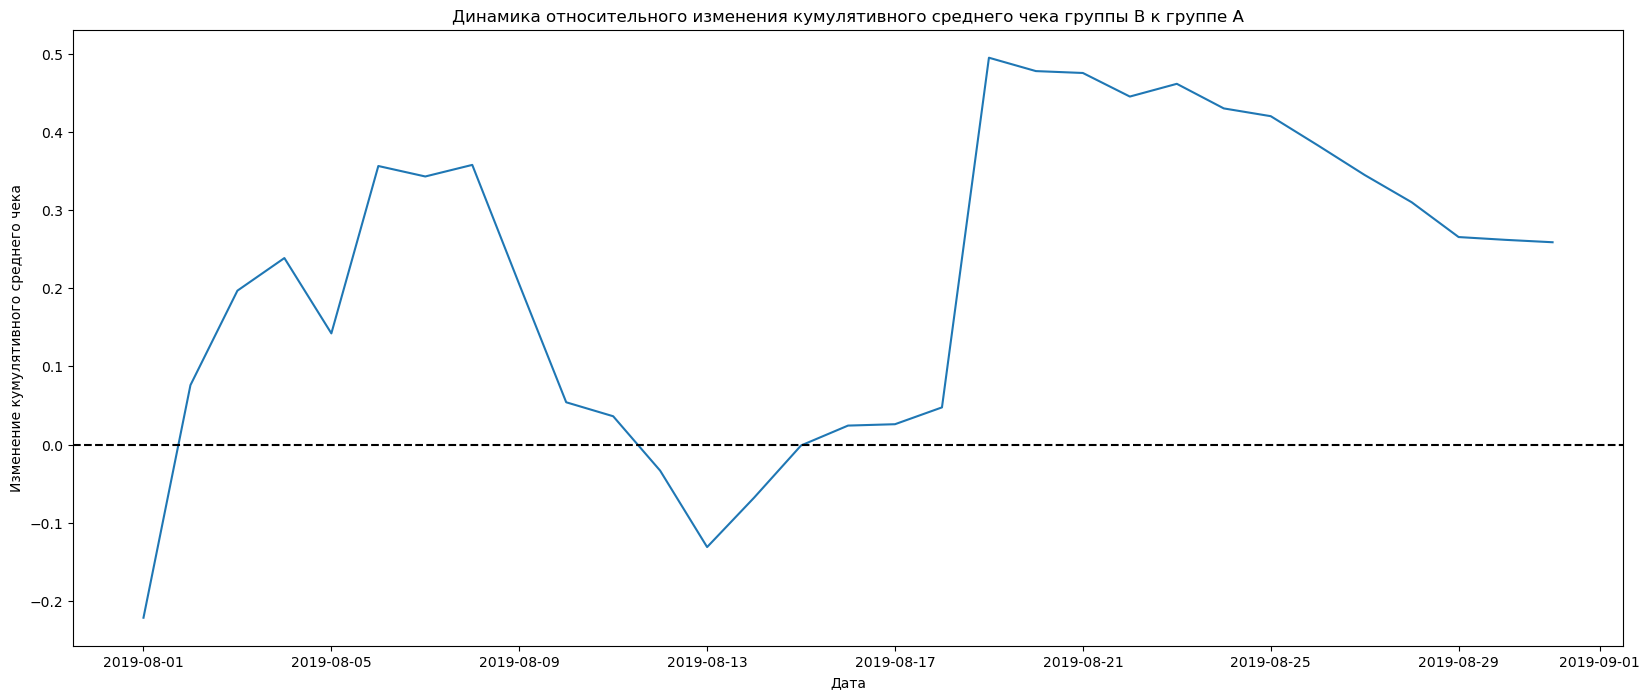

In [30]:
merge_cum_rev = cum_rev_a.merge(cum_rev_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(20,8))
plt.plot(merge_cum_rev['date'], (merge_cum_rev['revenueB']/merge_cum_rev['ordersB'])/(merge_cum_rev['revenueA']/merge_cum_rev['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Изменение кумулятивного среднего чека')
plt.xlabel('Дата')
plt.title('Динамика относительного изменения кумулятивного среднего чека группы В к группе А')
plt.show()

Здесь также наблюдаются несколько значительных скачков, и все тот же резкий рост в периоде 17-21 августа. Есть вероятность, что выбросы и аномальные заказы могли наблюдаться в обеих исследуемых группах.

### Кумулятивное среднеее количество заказов на посетителя по группам

Для дальнейшего изучения добавим к исследуюемому датасету еще одну колонку с конверсией (число заказов на посетителя) для всех данных, а затем построим на основе полученных данных график

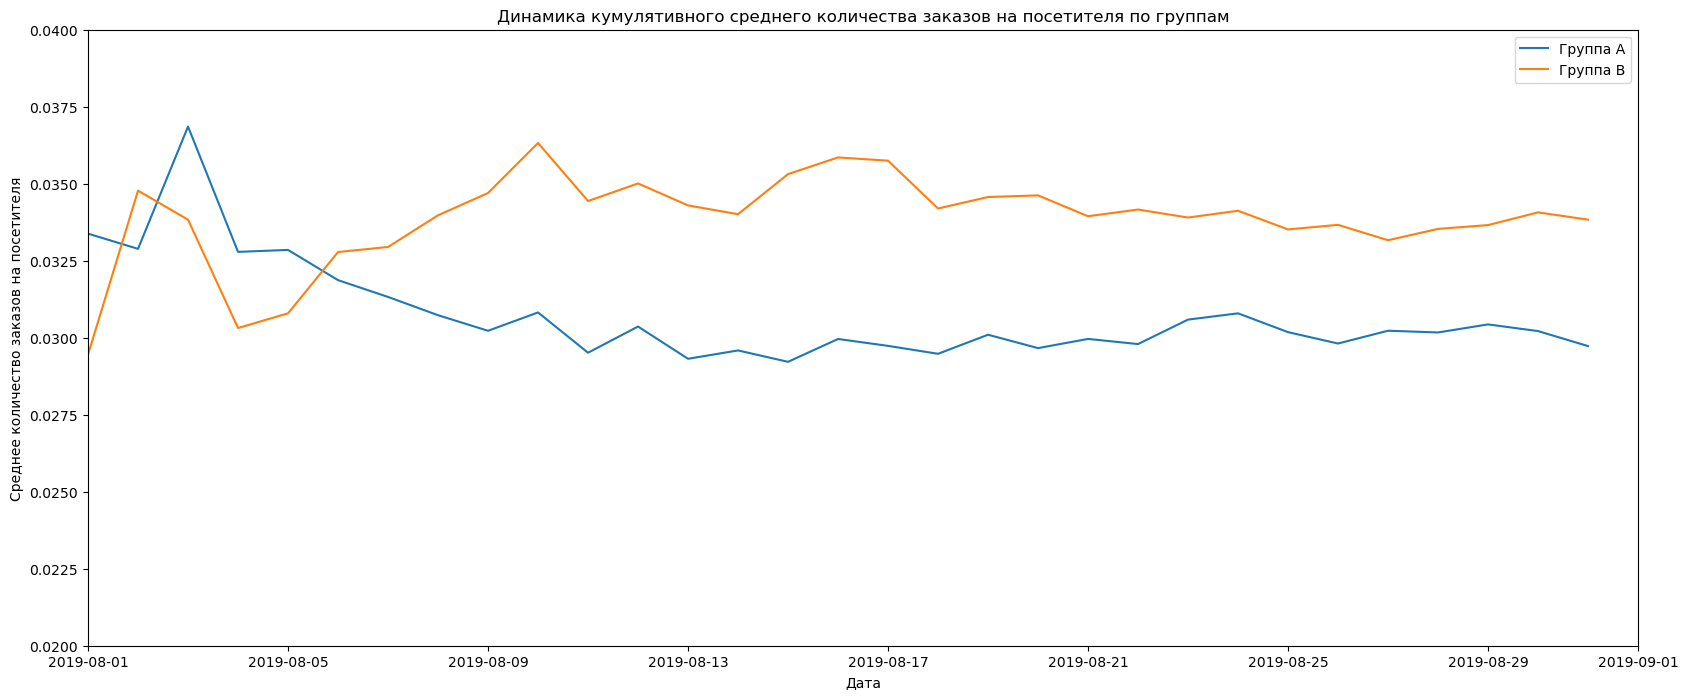

In [31]:
# считаем кумулятивную конверсию
cum_data['conversion'] = cum_data['orders']/cum_data['visitors']

# отделяем данные по группе A
cum_data_a = cum_data[cum_data['group']=='A']

# отделяем данные по группе B
cum_data_b = cum_data[cum_data['group']=='B']

# строим графики
plt.figure(figsize=(20,8))
plt.plot(cum_data_a['date'], cum_data_a['conversion'], label='Группа A')
plt.plot(cum_data_b['date'], cum_data_b['conversion'], label='Группа B')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-09-01', 0.02, 0.04]) 
plt.ylabel('Среднее количество заказов на посетителя')
plt.xlabel('Дата')
plt.title('Динамика кумулятивного среднего количества заказов на посетителя по группам')
plt.show()

После первой недели колебаний графики относительно стабилизировались, причем конверсия группы В несколько выше, чем конверсия группы А. Однако, в районе 17 августа можно заметить небольшой несимметричный всплеск конверсии по группе В. Это может быть как необычно большое количество заказов на посетителя, так и уже упоминавшиеся выше выбросы.

### Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A

Дополнительно также построим график относительного изменения кумулятивных конверсий и изучим его.

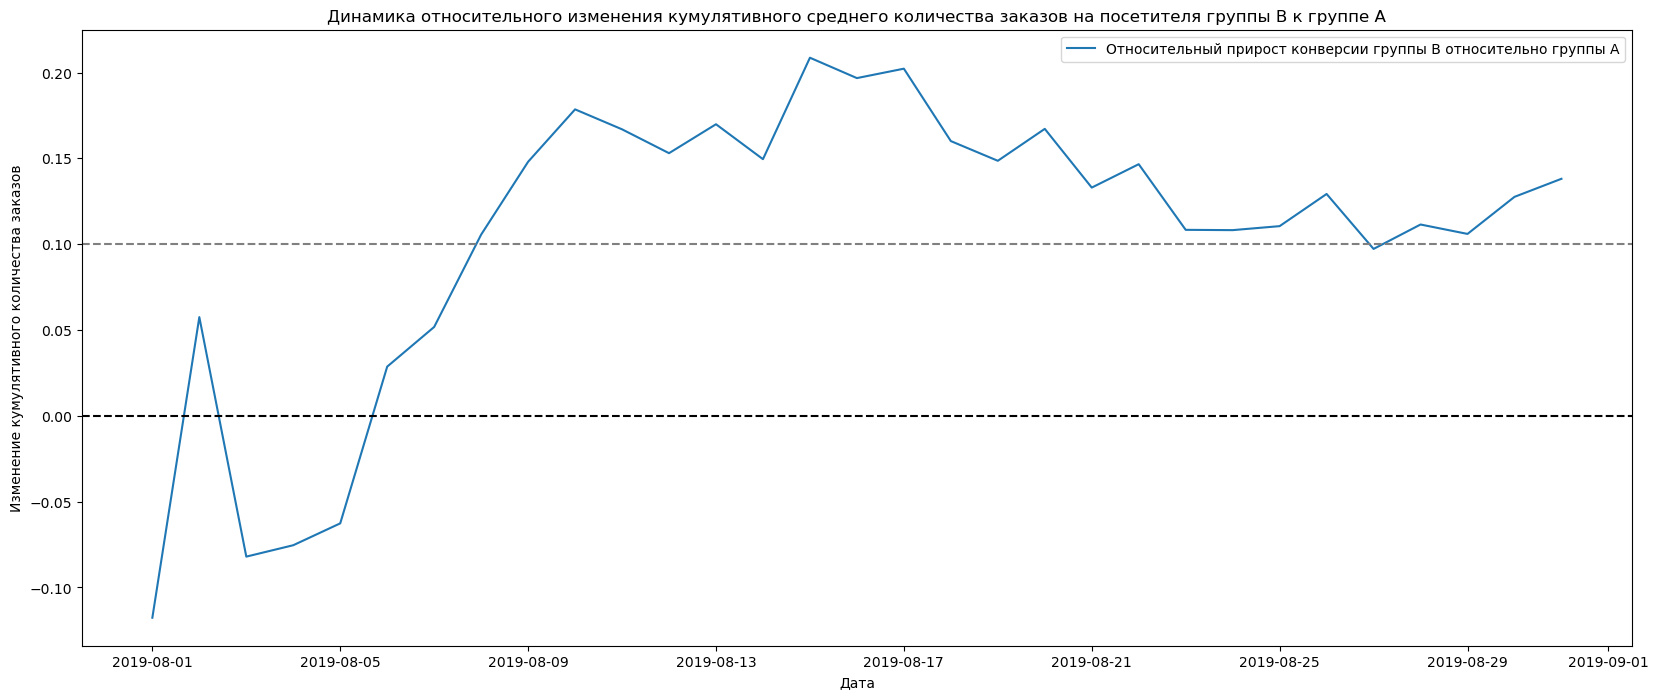

In [32]:
merge_cum_conv = cum_data_a[['date','conversion']].merge(cum_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(20,8))
plt.plot(merge_cum_conv['date'], merge_cum_conv['conversionB']/merge_cum_conv['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.ylabel('Изменение кумулятивного количества заказов')
plt.xlabel('Дата')
plt.title('Динамика относительного изменения кумулятивного среднего количества заказов на посетителя группы В к группе А')
plt.show()

В первые дни теста конверсия группы В была меньше конверсии группы А, а затем начала рост. В дальнейшем, наблюдался небольшой резкий рост, а затем - постепенное снижение.

По имеющемуся графику нельзя судить о стабильности роста конверсии группы В относительно группы А, поскольку данные не очищены от отдельных выбросов, поэтому далее изучим, где указанные выбросы могут быть, очистим данные и проведем исследование снова.

### Количество заказов по пользователям

Для дальнейшего исследования будем использовать датасет orders, в котором располагается информация по заказам пользователей.

In [33]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Сразу можно построить точечный график количества заказов и на нем определить, есть ли аномально большое количество заказов.

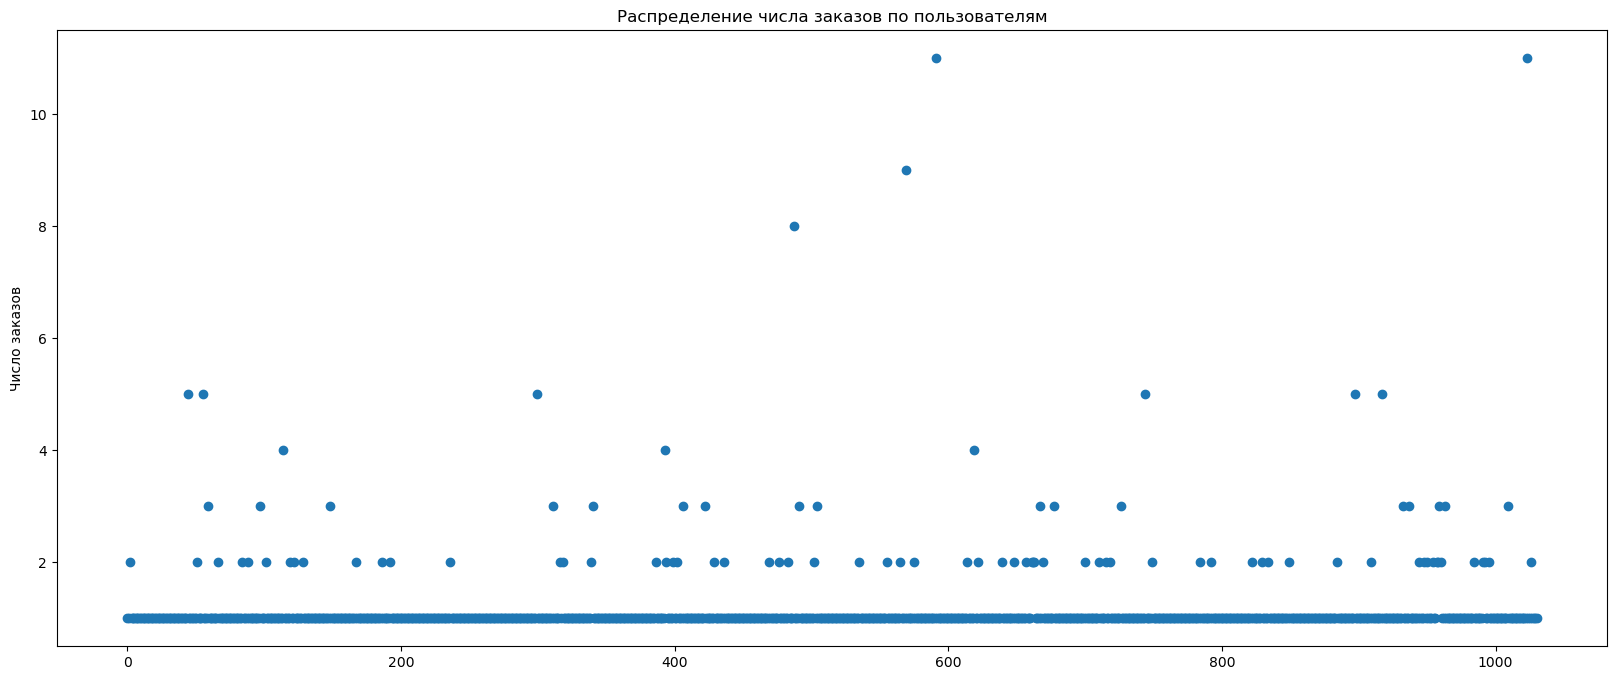

In [34]:
usr_orders = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

usr_orders.columns = ['visitorId', 'orders']
x_values = pd.Series(range(0,len(usr_orders)))
plt.figure(figsize=(20,8))
plt.scatter(x_values, usr_orders['orders']) 
plt.ylabel('Число заказов')
plt.title('Распределение числа заказов по пользователям')
plt.show()

Больше всего, что естественно, единичных заказов. Также есть достаточно много двух и трех заказов. Пока что на глаз сложно определить, какое количество заказов у пользователя считать аномально высоким, поэтому рассчитаем 95й и 99й перцентили для количества заказов.

### 95-й и 99-й перцентили количества заказов на пользователя. Граница для определения аномальных пользователей.

Расчет перцентилей необходим для определения границ выборки, после которых начинаются аномальные значения. Поскольку для сохранения репрезентативности необходимо удалять от 1 до 5% всех данных, посчитаем 95й и 99й перцентили.

In [35]:
print(np.percentile(usr_orders['orders'], [95, 99]))

[2. 4.]


Итого не более 5% пользователей оформили более 2 заказов, и не более 1% оформили более 4 заказов. Поэтому, для очистки данных от выбросов будем использовать границу в **3 заказа**.

### График стоимостей заказов

Проведем аналогичное исследование для стоимостей заказов и определим выбросы в них.

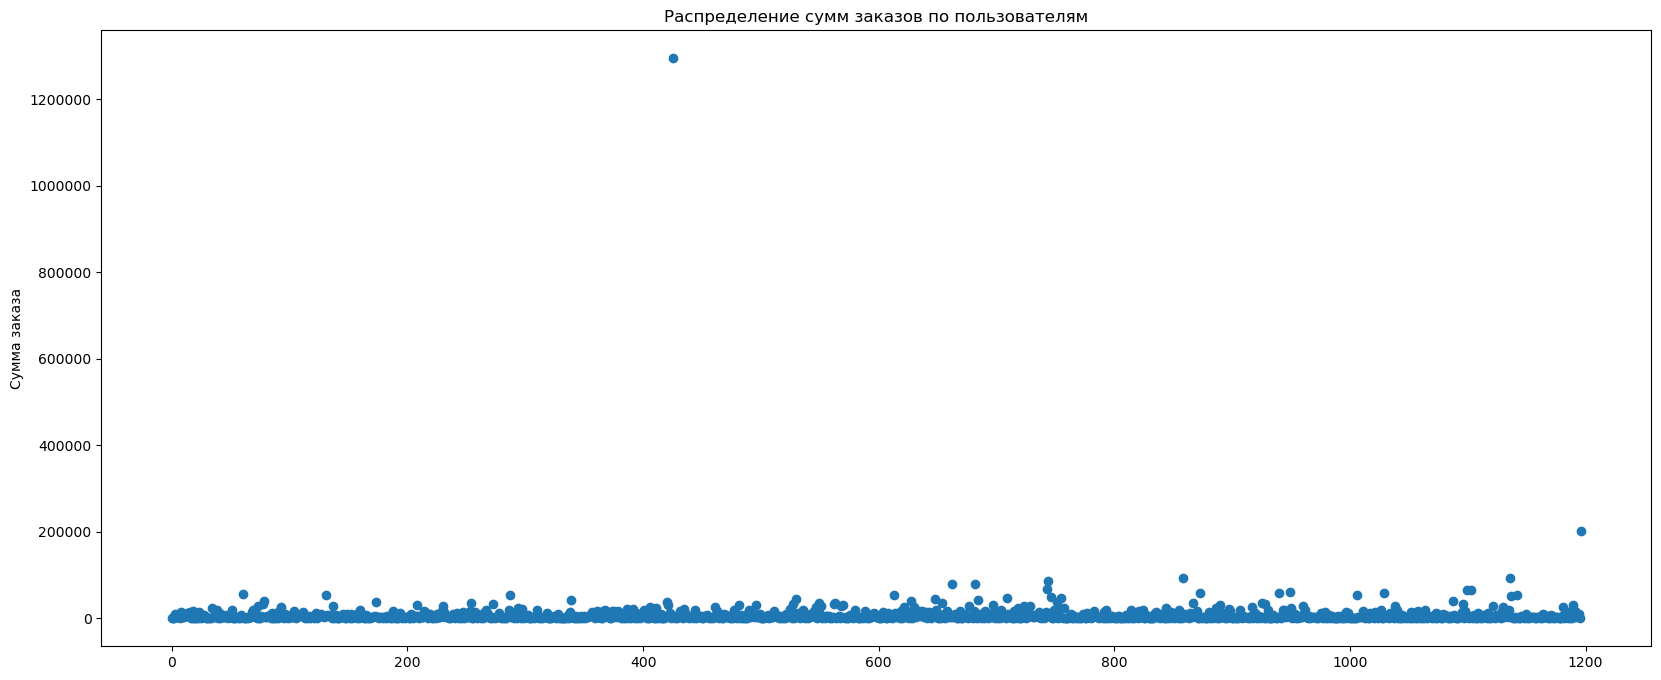

In [36]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(20,8))
plt.ticklabel_format(style='plain')
plt.scatter(x_values, orders['revenue']) 
plt.ylabel('Сумма заказа')
plt.title('Распределение сумм заказов по пользователям')
plt.show()

По графику видно, что действительно есть заказы с заоблачным чеком в 1 200 000,00, и 200 000,00. Остальные выбросы практически однородны, поэтому можно предположить, что большинство заказов имеют чек до 200 000,00.

Скорее всего, подобные единичные заказы значительно повлияли на рассматривавшиеся выше показатели, поэтому определенно есть необходимость определить верхнюю границу стоимости заказов.

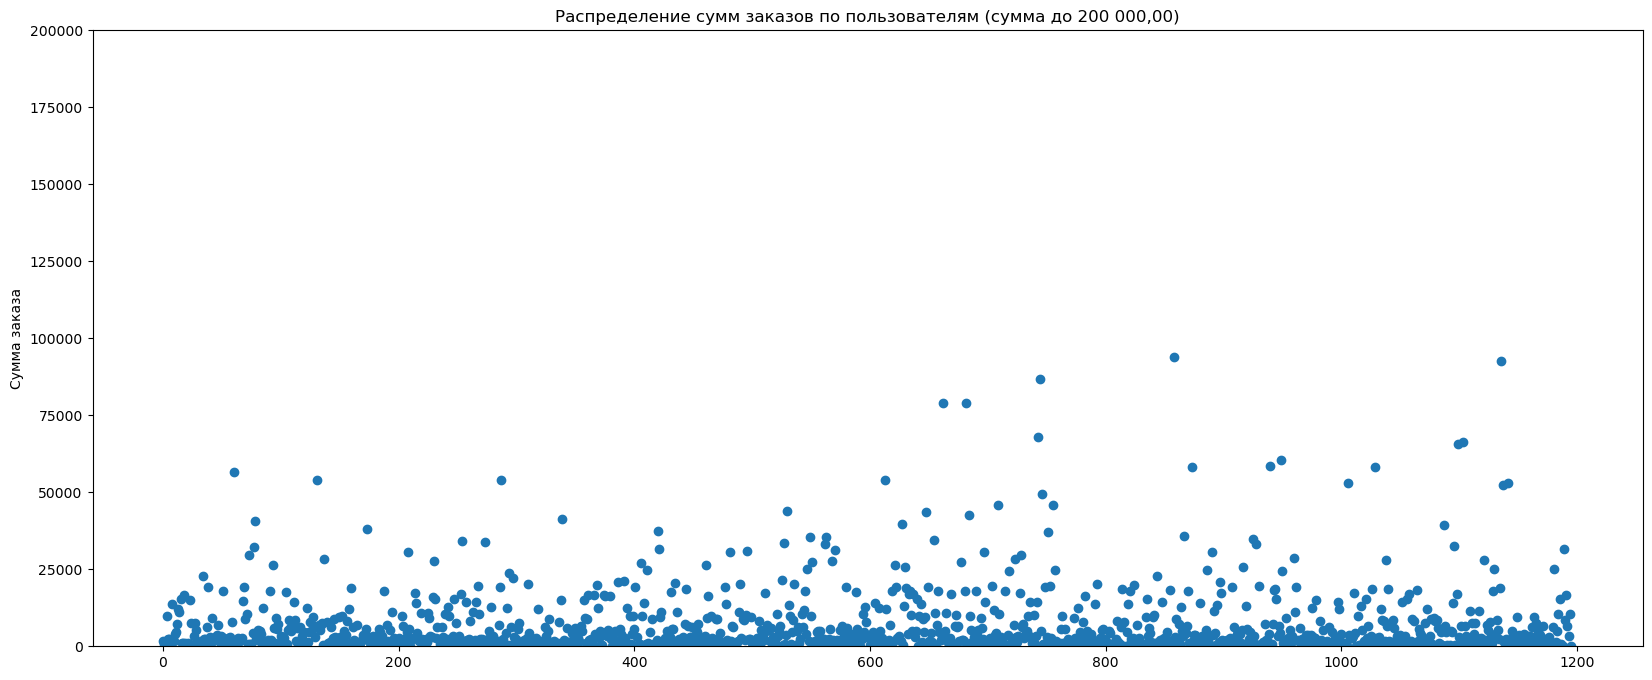

In [37]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(20,8))
plt.ticklabel_format(style='plain')
plt.scatter(x_values, orders['revenue']) 
plt.ylim(0,200000)
plt.ylabel('Сумма заказа')
plt.title('Распределение сумм заказов по пользователям (сумма до 200 000,00)')
plt.show()

При более детальном рассмотрении становится понятно, что большинство заказов имеют чек даже не меньше 200000, а меньше 100000. Это является дополнительным аргументов к ограничению верхнего потолка суммы заказа для исследования.

### 95-й и 99-й перцентили стоимости заказов. Граница для определения аномальных заказов.

Рассчитаем 95й и 99й перцентили для стоимости заказов.

In [38]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Итого не более 5% заказов имеют стоимость выше 28 000,00 и не более 1% - 58 233,20. Вполне логичным и справедливым будет взять для верхней границы стоимость заказа в размере **50 000,00**. 

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

По результатам вышепроведенного исследования можно сделать следующие выводы было определено, что в данных есть некоторое количество выбросов, а также были определены границы для очистки данных.

Теперь подсчитаем статистическую значимость по средним количеству заказво и чеку для данных до и после очистки, а затем оценим результаты самого проводимого А/В-теста.

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

In [39]:
vis_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
vis_daily_a.columns = ['date', 'vis_per_date_A']

vis_cum_a = vis_daily_a.apply(
    lambda x: vis_daily_a[vis_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'vis_per_date_A': 'sum'}
    ),
    axis=1,
)
vis_cum_a.columns = ['date', 'vis_cum_a']

vis_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
vis_daily_b.columns = ['date', 'vis_per_date_B']

vis_cum_b = vis_daily_b.apply(
    lambda x: vis_daily_b[vis_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'vis_per_date_B': 'sum'}
    ),
    axis=1,
)
vis_cum_b.columns = ['date', 'vis_cum_b']

ord_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ord_daily_a.columns = ['date', 'ord_per_date_A', 'rev_per_date_A']

ord_cum_a = ord_daily_a.apply(
    lambda x: ord_daily_a[ord_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'ord_per_date_A': 'sum', 'rev_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ord_cum_a.columns = [
    'date',
    'ord_cum_A',
    'rev_cum_A',
]

ord_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ord_daily_b.columns = ['date', 'ord_per_date_B', 'rev_per_date_B']

ord_cum_b = ord_daily_b.apply(
    lambda x: ord_daily_b[ord_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'ord_per_date_B': 'sum', 'rev_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ord_cum_b.columns = [
    'date',
    'ord_per_date_B',
    'rev_per_date_B',
]

data = (
    ord_daily_a.merge(
        ord_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(ord_cum_a, left_on='date', right_on='date', how='left')
    .merge(ord_cum_b, left_on='date', right_on='date', how='left')
    .merge(vis_daily_a, left_on='date', right_on='date', how='left')
    .merge(vis_daily_b, left_on='date', right_on='date', how='left')
    .merge(vis_cum_a, left_on='date', right_on='date', how='left')
    .merge(vis_cum_b, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ord_per_date_A  rev_per_date_A  ord_per_date_B_x  \
0 2019-08-01              24          148579                21   
1 2019-08-02              20           93822                24   
2 2019-08-03              24          112473                16   
3 2019-08-04              16           70825                17   
4 2019-08-05              25          124218                23   

   rev_per_date_B_x  ord_cum_A  rev_cum_A  ord_per_date_B_y  rev_per_date_B_y  \
0            101217         24     148579                21            101217   
1            165531         44     242401                45            266748   
2            114248         68     354874                61            380996   
3            108571         84     425699                78            489567   
4             92428        109     549917               101            581995   

   vis_per_date_A  vis_per_date_B  vis_cum_a  vis_cum_b  
0             719             713        719        713  


In [40]:
ord_usr_a = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ord_usr_a.columns = ['user_id', 'orders']

ord_usr_b = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ord_usr_b.columns = ['user_id', 'orders']

sample_a = pd.concat(
    [
        ord_usr_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['vis_per_date_A'].sum() - len(ord_usr_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        ord_usr_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['vis_per_date_B'].sum() - len(ord_usr_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:',"{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print('Различие в средних:',"{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

p-value: 0.017
Различие в средних: 0.138


Поскольку полученное значение p-value меньше 0.05, отвергаем нулевую гипотезу и заявляем о том, что в сырых данных есть различия между средним числом заказов в группах.

При этом, относительное различие составляет 13,8% в пользу группы В.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Теперь рассчитаем статистическую значимость различий в среднем чеке заказа между группами по сырым данным. Здесь не придется создавать дополнительные датафреймы со сводными данными, можем рассчитать сразу по готовому датасету.

Гипотезы будут следующими: Нулевая - различий между средним чеком по группам нет; Альтернативная - различия в среднем чеке между группами есть.

In [41]:
print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Различие в средних:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.729
Различие в средних: 0.259


Ввиду того, что p-value значительно выше 0.05, альтернативная гипотеза отвергается. Значит различий между средним чеком нет. При этом есть различия между уровнем среднего, что показывает число 0.259. Это означает, что в общем и целом чек по группе В выше. Однако, ввиду того, что p-value значительно больше установленной границы в 0,05, различие в среднем чеке в размере 25,9% является величиной, полученной случайно. Возможно, это может быть обусловлено иными причинами, выходящими за рамки настоящего А/В-теста.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Для начала определим данные, которые должны быть исключены как выбросы.

Ранее было определено, что верхней границей для количества заказов является **3 заказа** и сумма заказа **50 000,00 рублей**.

In [42]:
max_orders = 3
max_price = 50000

In [43]:
many_orders = pd.concat(
    [
        ord_usr_a[ord_usr_a['orders'] > max_orders]['user_id'],
        ord_usr_b[ord_usr_b['orders'] > max_orders]['user_id'],
    ],
    axis=0,
)
expensive_orders = orders[orders['revenue'] > max_price]['visitorId']
abnormal_users = (
    pd.concat([many_orders, expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print(abnormal_users.shape[0]) 

1099    148427295
18      199603092
23      237748145
1137    759473111
949     887908475
dtype: int64
26


Итого 26 пользователей-выбросов. Поэтому очистим данные и изучим показатели для очищенных данных по ранее выдвигавшимся гипотезам относительно среднего количества заказов на посетителя и относительно среднего чека заказа.

In [44]:
sample_a_f = pd.concat(
    [
        ord_usr_a[
            np.logical_not(ord_usr_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['vis_per_date_A'].sum() - len(ord_usr_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_f = pd.concat(
    [
        ord_usr_b[
            np.logical_not(ord_usr_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['vis_per_date_B'].sum() - len(ord_usr_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(sample_a_f, sample_b_f)[1]))
print('Различие в средних:','{0:.3f}'.format(sample_b_f.mean()/sample_a_f.mean()-1)) 

p-value: 0.011
Различие в средних: 0.158


На всякий случай напомним себе гипотезы.

Нулевая: различий в среднем количестве заказов между группами нет. 

Альтернативная: различия в среднем между группами есть.

По полученным показателям, поскольку полученное значение p-value меньше 0.05, отвергаем нулевую гипотезу и заявляем о том, что в отфильтрованных данных есть различия между средним числом заказов в группах.

При этом, относительное различие составляет 15,8% в пользу группы В, увеличившись на 2% от "сырых" данных.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Теперь аналогичным образом оценим различия среднего чека заказа между группами по очищенным данным. Здесь гипотезы будут следующими.

Нулевая - различий между средним чеком по группам нет; Альтернативная - различия в среднем чеке между группами есть.

In [45]:
print('p-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Различие в средних:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value: 0.819
Различие в средних: 0.024


Оказалось, что величина p-value выросла относительно "сырых" данных, и осталась значительно выше 0.05. Поэтому альтернативная гипотеза отвергается, что говорит о том, что различий между средним чеком нет. При этом есть различия между уровнем среднего, что показывает число 0.024. Примечательно, что предыдущий показатель был на 0,235 выше и составлял 0.259 Это означает, что в общем и целом чек по группе В выше, однако в очищенных данных разница между средними чеками меньше.

### Выводы по результатам теста

Теперь, имея на руках результаты по очищенным данным, и сами очищенные данные, мы можем провести сравнение групп А/В-теста сразу по сырым и очищенным данным и изучить поведение графиков. 

Скорее всего, отдельные аспекты изменятся и картина станет более понятной, на основании чего можно будет принимать решение о результатах теста.

Сначала создадим очищенный от выбросов датасет.

In [46]:
orders_f = orders.query('visitorId not in @abnormal_users')
orders_f.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [47]:
orders_agg_f = date_group.apply(
    lambda x: orders_f[
        np.logical_and(
            orders_f['date'] <= x['date'], orders_f['group'] == x['group'], 
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])
orders_agg_f.head(5)

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,19,19,78258
175,2019-08-02,A,43,37,236601
173,2019-08-02,B,42,41,240301
291,2019-08-03,A,67,61,349074


In [48]:
visitors_agg = date_group.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_agg.head(5)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [49]:
cum_data_f = orders_agg_f.merge(
    visitors_agg, left_on=['date', 'group'], right_on=['date', 'group']
)
cum_data_f.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
cum_data_f.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,19,19,78258,713
2,2019-08-02,A,43,37,236601,1338
3,2019-08-02,B,42,41,240301,1294
4,2019-08-03,A,67,61,349074,1845


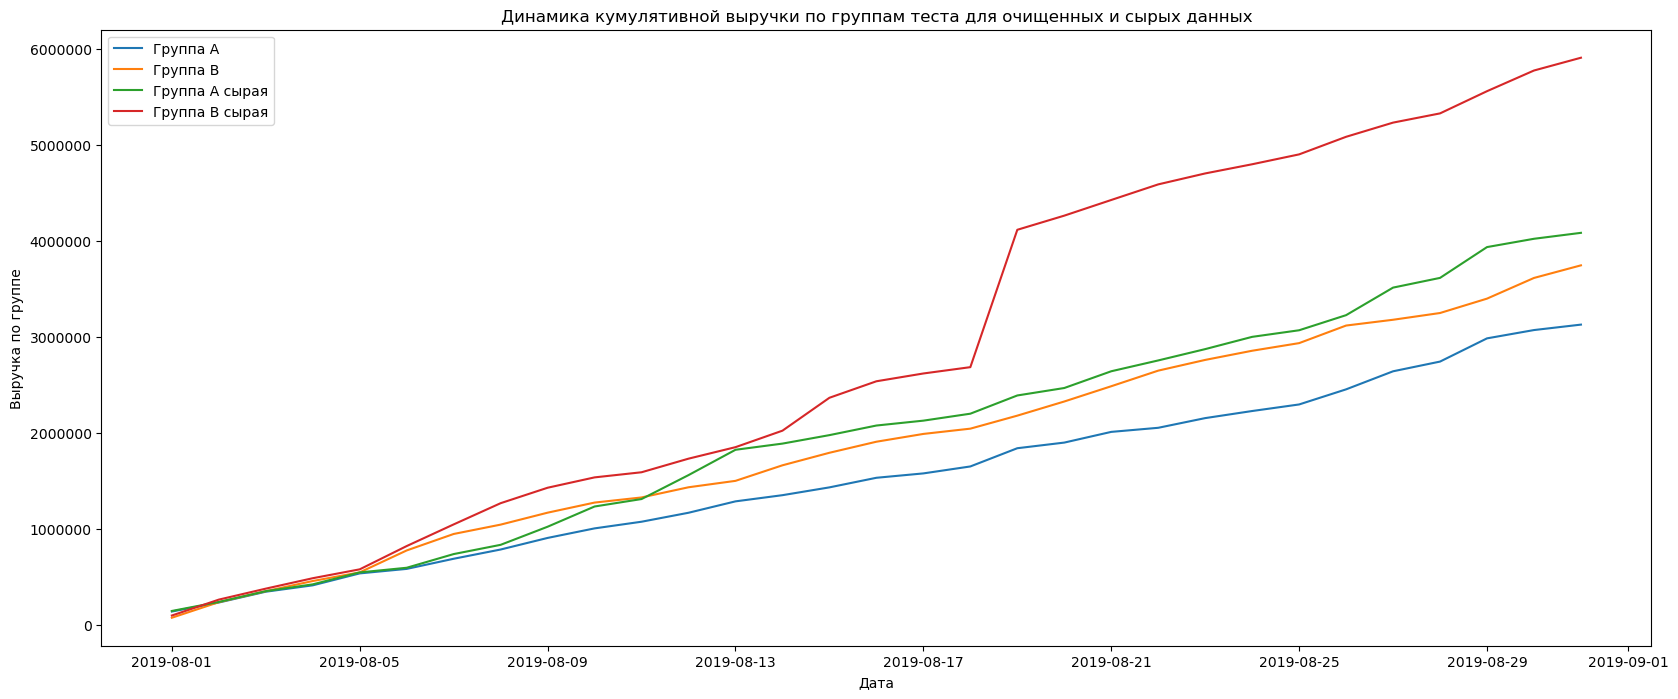

In [50]:
cum_rev_a_f = cum_data_f[cum_data_f['group']=='A'][['date','revenue', 'orders']]

cum_rev_b_f = cum_data_f[cum_data_f['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(20,8))
plt.ticklabel_format(style='plain')
plt.plot(cum_rev_a_f['date'], cum_rev_a_f['revenue'], label='Группа A')
plt.plot(cum_rev_b_f['date'], cum_rev_b_f['revenue'], label='Группа B')
plt.plot(cum_rev_a['date'], cum_rev_a['revenue'], label='Группа A сырая')
plt.plot(cum_rev_b['date'], cum_rev_b['revenue'], label='Группа B сырая')
plt.legend() 
plt.ylabel('Выручка по группе')
plt.xlabel('Дата')
plt.title('Динамика кумулятивной выручки по группам теста для очищенных и сырых данных')
plt.show()

Теперь на графике видно, что после очистки данных графики роста кумулятивной выручки по группам стали немного ниже, но при этом кумулятивная выручка по группе В стабильно выше выручки по группе А, и оба графика равномерно увеличиваются.

Таким образом, группа В вне зависимости от выбросов показывает по выручке результаты лучше, чем группа А.

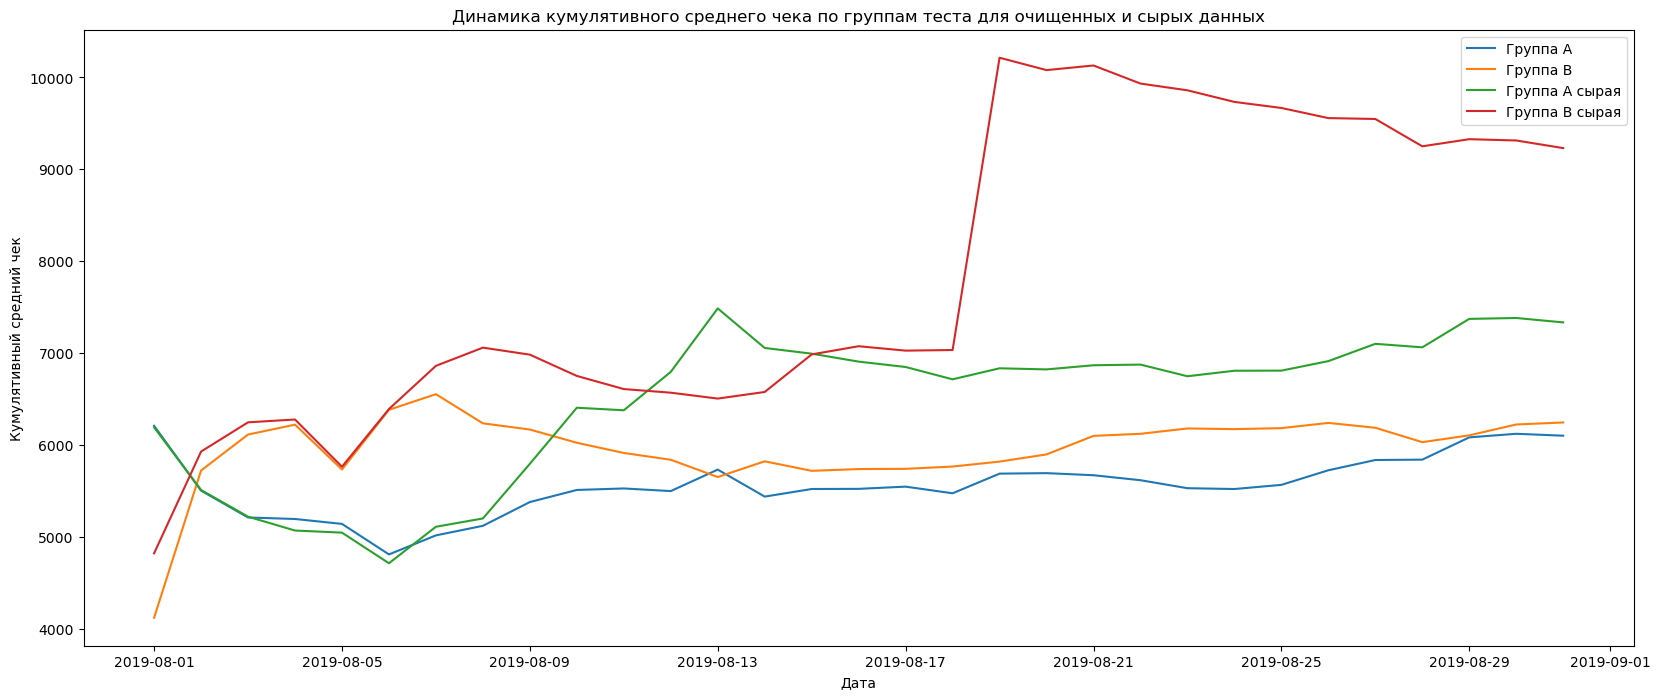

In [51]:
plt.figure(figsize=(20,8))
plt.plot(cum_rev_a_f['date'], cum_rev_a_f['revenue']/cum_rev_a_f['orders'], label='Группа A')
plt.plot(cum_rev_b_f['date'], cum_rev_b_f['revenue']/cum_rev_b_f['orders'], label='Группа B')
plt.plot(cum_rev_a['date'], cum_rev_a['revenue']/cum_rev_a['orders'], label='Группа A сырая')
plt.plot(cum_rev_b['date'], cum_rev_b['revenue']/cum_rev_b['orders'], label='Группа B сырая')
plt.legend() 
plt.ylabel('Кумулятивный средний чек')
plt.xlabel('Дата')
plt.title('Динамика кумулятивного среднего чека по группам теста для очищенных и сырых данных')
plt.show()

В первой половине теста средний чек по группе В резко вырос и снижался, а по группе А постепенно снижался и затем перешел в рост. Затем произошел разворот тренда и в районе 13 августа их траектории роста пересеклись, после чего наметилось небольшое расхождение и затем их траектории практически равномерно установились на уровне группы В несколько выше группы А.

В целом, показатели группы В по среднему чеку ненамного лучше группы А, но могут быть подвержены единичным изменениям в обе стороны ввиду изменчивости покупательского поведения.

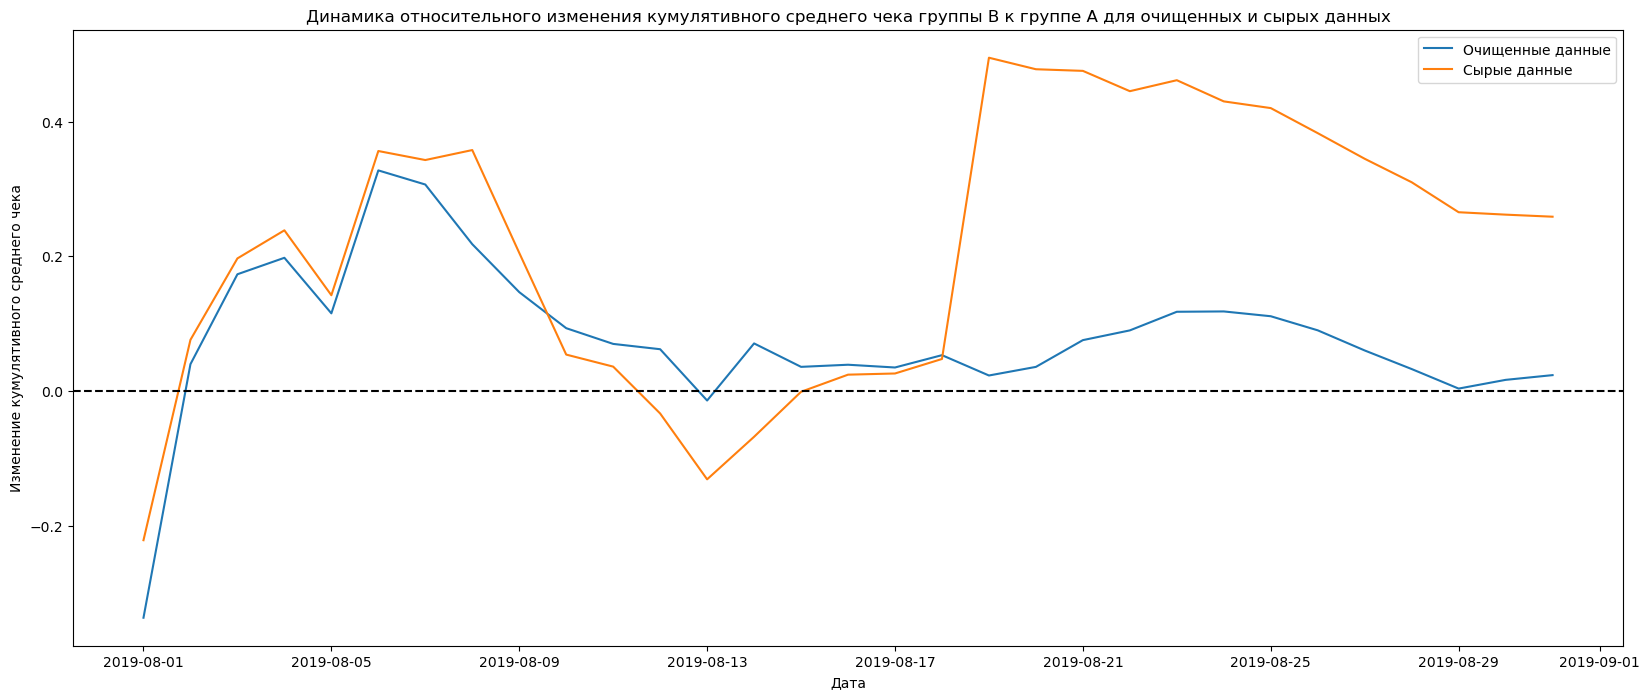

In [52]:
merge_cum_rev_f = cum_rev_a_f.merge(cum_rev_b_f, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(20,8))
plt.plot(merge_cum_rev_f['date'], (merge_cum_rev_f['revenueB']/merge_cum_rev_f['ordersB'])/(merge_cum_rev_f['revenueA']/merge_cum_rev_f['ordersA'])-1, label='Очищенные данные')
plt.plot(merge_cum_rev['date'], (merge_cum_rev['revenueB']/merge_cum_rev['ordersB'])/(merge_cum_rev['revenueA']/merge_cum_rev['ordersA'])-1, label='Сырые данные')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend() 
plt.ylabel('Изменение кумулятивного среднего чека')
plt.xlabel('Дата')
plt.title('Динамика относительного изменения кумулятивного среднего чека группы В к группе А для очищенных и сырых данных')
plt.show()

График изменения кумулятивного среднего чека по группе В относительно группы А изменился более значительно. Исчез выброс, и в целом траектория его изменения показывает, что группа В показывает незначительно лучшие результаты, чем группа А. Тем не менее, положительные показатели в остальных аспектах могут дополнить эту траекторию ростом эффективности от масштаба, а значит группа В, ввиду более высокой кумулятивной выручки, выглядит предпочтительнее.

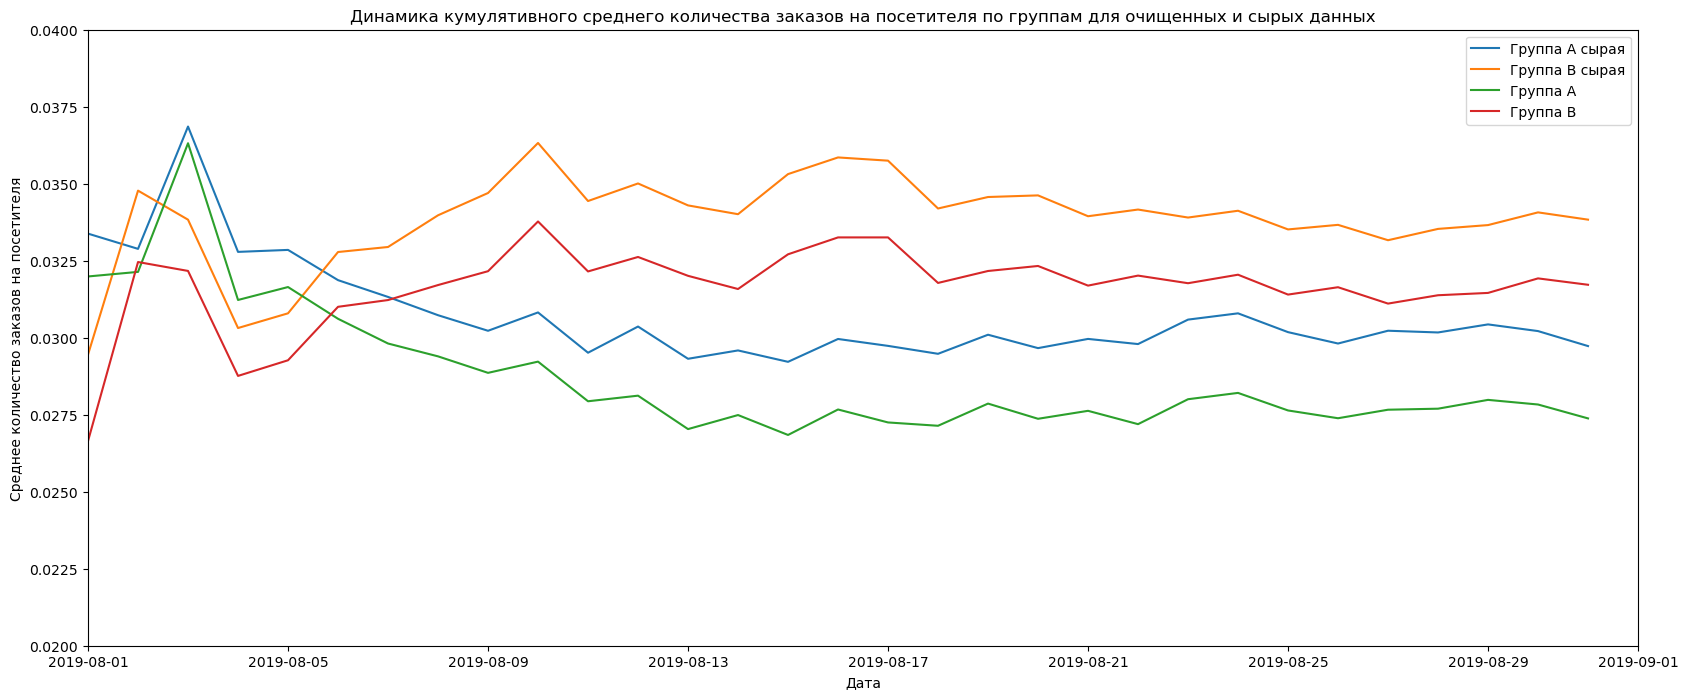

In [53]:
# считаем кумулятивную конверсию
cum_data_f['conversion'] = cum_data_f['orders']/cum_data_f['visitors']

# отделяем данные по группе A
cum_data_a_f = cum_data_f[cum_data_f['group']=='A']

# отделяем данные по группе B
cum_data_b_f = cum_data_f[cum_data_f['group']=='B']

# строим графики
plt.figure(figsize=(20,8))
plt.plot(cum_data_a['date'], cum_data_a['conversion'], label='Группа A сырая')
plt.plot(cum_data_b['date'], cum_data_b['conversion'], label='Группа B сырая')
plt.plot(cum_data_a_f['date'], cum_data_a_f['conversion'], label='Группа A')
plt.plot(cum_data_b_f['date'], cum_data_b_f['conversion'], label='Группа B')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-09-01', 0.02, 0.04]) 
plt.ylabel('Среднее количество заказов на посетителя')
plt.xlabel('Дата')
plt.title('Динамика кумулятивного среднего количества заказов на посетителя по группам для очищенных и сырых данных')
plt.show()

Графики кумулятивной конверсии практически не изменились, только лишь понизился их общий уровень, примерно на 0,0025. Конверсия группы В оказывается все еще выше, чем конверсия группы А до очистки. В свою очередь, этот факт дополнительно улучшает позиции группы В.

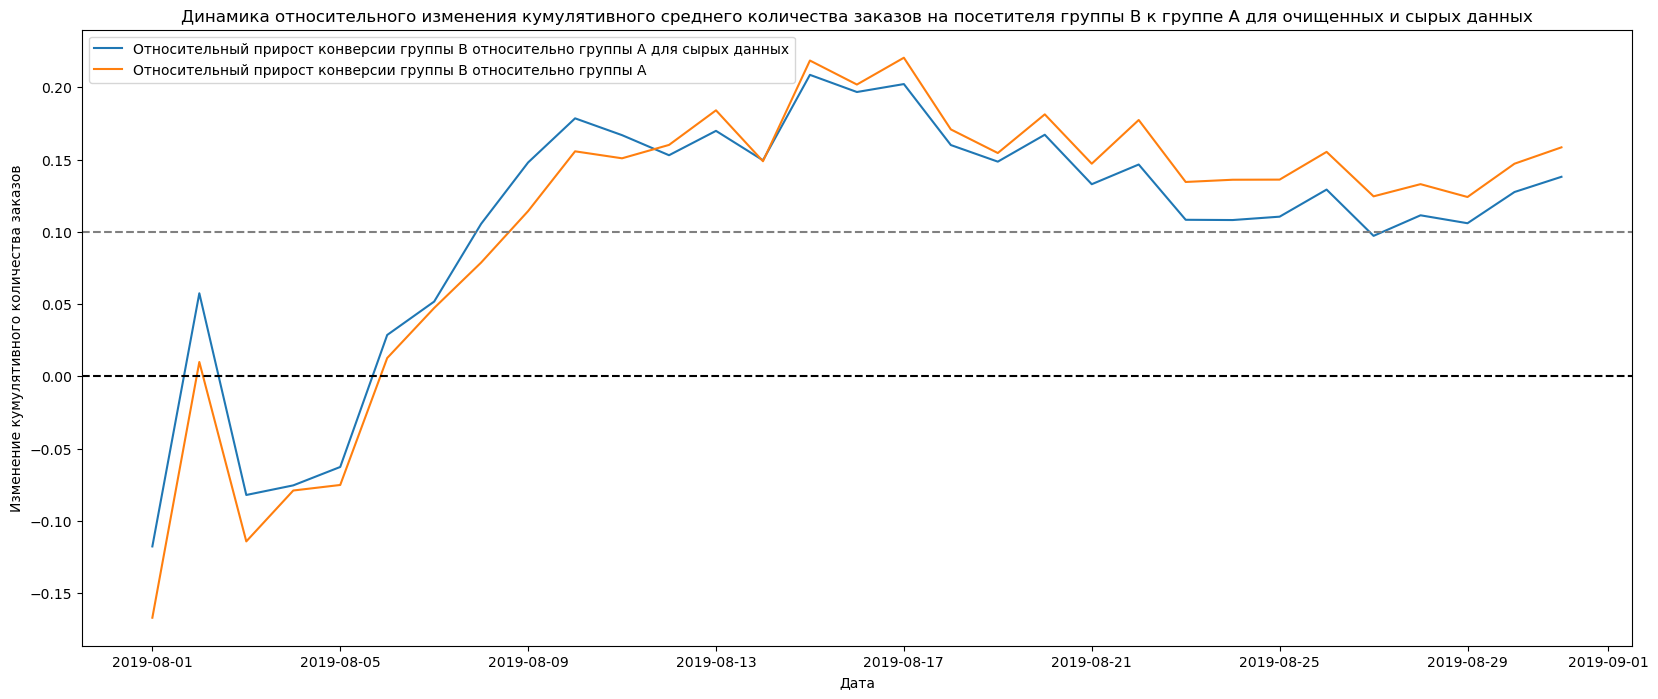

In [54]:
merge_cum_conv_f = cum_data_a_f[['date','conversion']].merge(cum_data_b_f[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(20,8))
plt.plot(merge_cum_conv['date'], merge_cum_conv['conversionB']/merge_cum_conv['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A для сырых данных")
plt.plot(merge_cum_conv_f['date'], merge_cum_conv_f['conversionB']/merge_cum_conv_f['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.ylabel('Изменение кумулятивного количества заказов')
plt.xlabel('Дата')
plt.title('Динамика относительного изменения кумулятивного среднего количества заказов на посетителя группы В к группе А для очищенных и сырых данных')
plt.show()

После очистки данных картина в относительном приросте конверсии группы В относительно группы А изменилась: относительный прирост по очищенным данным стал выше, при этом он установился несколько выше 10%. Это в очередной раз говорит о том, что группа В более эффективна и доходна.

**Итог теста**

По результатам теста, в особенности после очистки данных от выбросов, можно заявить, что тест успешен. По его результатам группа В показала б*о*льшую эффективность в экономических показателях, чем группа А.

При этом, было установлено, что между группами имеется различие в среднем количестве заказов, при отсутствии различий в среднем чеке.

Поэтому, при учете всех показателей, следует признать победу группы В и остановить тест. 

После этого можно начать проверять иные гипотезы и проводить иные тесты.

## Выводы

### Выводы 1й части

По итогам проведенного анализа, гипотезы были приоритезированы по методике RICE и в порядке приоритетности располагаются так:

In [55]:
result

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


В максимальном приоритете - добавление функции подписки на все основные страницы. Это логично: функция сразу будет доведена до каждого пользователя, и так или иначе, пользователи будут получать уведомления о разных событиях магазина - а значит скорее всего будут чаще посещать его, зацепляться глазом за какие-либо товары и увеличивать выручку.

Блок рекомендаций в части охвата также логично, что достаточно приоритетен: люди могут искать похожие товары, различные дополнительные аксессуары, запчасти, расходные материалы и прочее, связанное с основным товаром, ради которого они приходят. Так сделано во многих интернет-магазинах и часто оно работает. Сопутствующие товары также увеличат выручку.

Новые каналы привлечения по-прежнему остались в топ-3, и это также логично: с новыми каналами увеличится и охват, особенно среди привлеченных по этим каналам. В остальном - предположение по цели гипотезы остается прежним. Новые пользователи принесут новую выручку, но конечная эффективность должна будет оцениваться по показателям конверсии и дохода на пользователя.

### Выводы 2й части

По результатам проведенного А/В-теста для двух групп покупателей, было установлено, что в группе В среднее количество заказов выше при отстуствии различий в среднем чеке заказа между группами. Дополнительно, конверсия по группе В также оказалась выше. Таким образом, за счет того, что при равном чеке, в группе В будет больше заказов, покупатели этой группы будут приносить больше дохода компании. Это дополнительно подтверждает график кумулятивного дохода по обеим группам после очистки от выбросов.

В совокупности можно сделать вывод, что группа В продемонстрировала в течение месяца проведения теста более высокие результаты, соответственно, необходимо принять к исполнению проверявшуюся гипотезу или улучшение, которое использовалось для пользователей группы В.

После признания теста успешным, можно перейти к тестированию других гипотез и изучению их влияния на покупательскую активность.